# Home Credit Default Risk

# Library used

In [255]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz

# Machine Learning Library
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

## Data

In [256]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [257]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis

In [258]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Is data unbalanced ? 

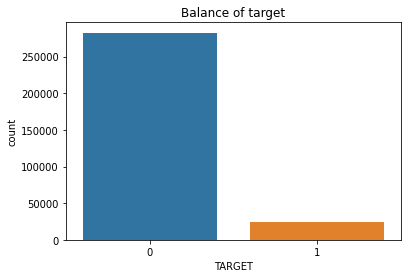

In [259]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

In [260]:
print("Unbalanced data on the TARGET column:")
print(app_train['TARGET'].value_counts())

Unbalanced data on the TARGET column:
0    282686
1     24825
Name: TARGET, dtype: int64


The data is very unbalanced.

## Handling unbalanced data

In [261]:
msk = app_train['TARGET'] == 1
num_to_oversample = len(app_train) - 2*msk.sum()
df_positive_oversample = app_train[msk].sample(n=num_to_oversample, replace=True)
df_train_oversample = pd.concat([app_train, df_positive_oversample])
app_train = df_train_oversample
print("Balanced data after oversampling:\n")
print(app_train['TARGET'].value_counts())

Balanced data after oversampling:

1    282686
0    282686
Name: TARGET, dtype: int64


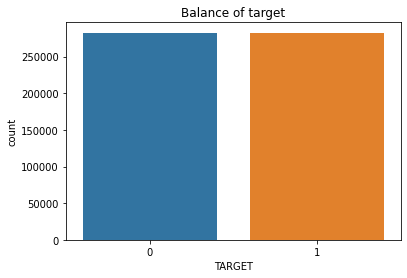

In [262]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

## Gender distribution

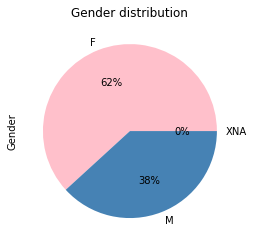

In [263]:
gender_group = app_train.groupby(['CODE_GENDER'])
gender_group.size().plot(kind='pie', 
                         ylabel='Gender', 
                         colors=['pink', 'steelblue', 'pink'], 
                         title='Gender distribution',
                         autopct='%.0f%%')
plt.show()

### Contract type distribution

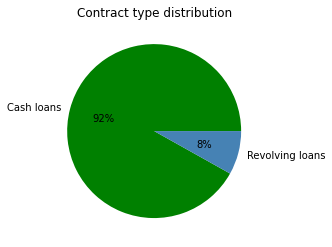

In [264]:
contract_group = app_train.groupby(['NAME_CONTRACT_TYPE'])
contract_group.size().plot(kind='pie', 
                           ylabel='', 
                           colors=['green', 'steelblue'], 
                           title='Contract type distribution',
                           autopct='%.0f%%')
plt.show()

## Days Birth feature

### Informations

In [265]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    565372.000000
mean         42.486256
std          11.854091
min          20.517808
25%          32.495890
50%          41.246575
75%          52.098630
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Minimum and maximum value

In [266]:
mini = abs(app_train['DAYS_BIRTH'].max())
if mini > 365:
    print("Days birth min :", mini/365, "days" )
else:
    print("Days birth min :", mini, "days" )
    
maxi = abs(app_train['DAYS_BIRTH'].min())
print("Days birth max :", maxi/365, "years" )

Days birth min : 20.517808219178082 days
Days birth max : 69.12054794520547 years


### Boxplots

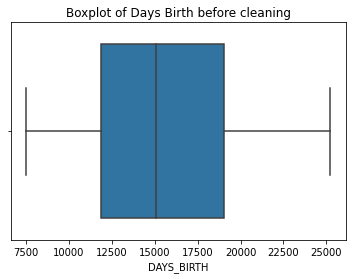

In [267]:
ax = sns.boxplot(x=abs(app_train['DAYS_BIRTH']))
plt.title('Boxplot of Days Birth before cleaning')
plt.show()

## Missing values

In [268]:
print("30 first columns filled with the most NaN values with their percentage:")
((app_train.isnull().sum()/app_train.shape[0])*100).sort_values(ascending=False).head(30)

30 first columns filled with the most NaN values with their percentage:


COMMONAREA_MODE             71.856937
COMMONAREA_AVG              71.856937
COMMONAREA_MEDI             71.856937
NONLIVINGAPARTMENTS_MEDI    71.450655
NONLIVINGAPARTMENTS_AVG     71.450655
NONLIVINGAPARTMENTS_MODE    71.450655
FONDKAPREMONT_MODE          70.493940
LIVINGAPARTMENTS_MEDI       70.488103
LIVINGAPARTMENTS_AVG        70.488103
LIVINGAPARTMENTS_MODE       70.488103
FLOORSMIN_MEDI              70.015848
FLOORSMIN_AVG               70.015848
FLOORSMIN_MODE              70.015848
YEARS_BUILD_AVG             68.799658
YEARS_BUILD_MEDI            68.799658
YEARS_BUILD_MODE            68.799658
OWN_CAR_AGE                 67.595318
LANDAREA_AVG                61.919586
LANDAREA_MODE               61.919586
LANDAREA_MEDI               61.919586
BASEMENTAREA_MODE           61.312552
BASEMENTAREA_MEDI           61.312552
BASEMENTAREA_AVG            61.312552
NONLIVINGAREA_AVG           58.217245
NONLIVINGAREA_MODE          58.217245
NONLIVINGAREA_MEDI          58.217245
EXT_SOURCE_1

# Data cleanup 

## Label encoding

In [269]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
16 columns were label encoded.


## Missing and infinite values

In [270]:
# Replacing Infinite values with NaN values
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [271]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_train)
imputer = imputer.fit_transform(app_train)
app_train = pd.DataFrame(imputer, columns = app_train.columns.values.tolist())

In [272]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_test)
imputer = imputer.fit_transform(app_test)
app_test = pd.DataFrame(imputer, columns = app_test.columns.values.tolist())

## Days Employed feature

### Informations 

In [273]:
app_train['DAYS_EMPLOYED'].describe()

count    565372.000000
mean      54002.683205
std      132168.353143
min      -17912.000000
25%       -2466.000000
50%       -1119.000000
75%        -337.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

### Minimum and maximum values

In [274]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "years" )
else:
    print("Days employed min :", mini, "days" )
    
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed min : 1000.6657534246575 years
Days employed max : 49.07397260273972 years


We can see an anomaly : the biggest 'Days Employed' value is around 1000 years !

### Boxplots

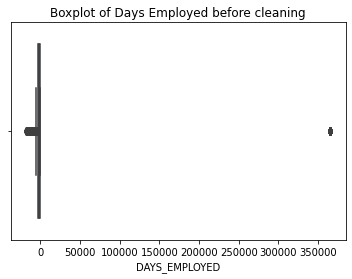

In [275]:
ax = sns.boxplot(x=app_train['DAYS_EMPLOYED'])
plt.title('Boxplot of Days Employed before cleaning')
plt.show()

### Removing anomalies

In [276]:
app_train.drop(app_train.index[(app_train["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)
app_test.drop(app_test.index[(app_test["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

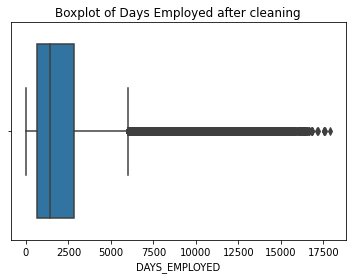

In [277]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))
plt.title('Boxplot of Days Employed after cleaning')
plt.show()

# Making our model

## Correlations

In [278]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n')
print(correlations.tail(15))
print('\nMost Negative Correlations:\n')
print(correlations.head(15))

Most Positive Correlations:

REG_CITY_NOT_LIVE_CITY         0.069928
DAYS_ID_PUBLISH                0.071422
WALLSMATERIAL_MODE             0.073409
FLAG_DOCUMENT_3                0.076917
HOUSETYPE_MODE                 0.077204
REG_CITY_NOT_WORK_CITY         0.078279
EMERGENCYSTATE_MODE            0.080237
CODE_GENDER                    0.086966
DAYS_LAST_PHONE_CHANGE         0.111275
REGION_RATING_CLIENT           0.115982
DAYS_BIRTH                     0.119383
REGION_RATING_CLIENT_W_CITY    0.120228
NAME_EDUCATION_TYPE            0.122877
DAYS_EMPLOYED                  0.147664
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:

EXT_SOURCE_2                 -0.275808
EXT_SOURCE_3                 -0.269350
EXT_SOURCE_1                 -0.193669
AMT_GOODS_PRICE              -0.097030
FLOORSMAX_AVG                -0.083391
FLOORSMAX_MEDI               -0.082883
FLOORSMAX_MODE               -0.081037
REGION_POPULATION_RELATIVE   -0.078600


# Splitting data into train and validation

In [279]:
Xdf = app_train
Xdf.drop("TARGET", axis = 1)
X = np.array(Xdf)

y = np.array(app_train["TARGET"])

In [280]:
# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# Logistic regression

Our problem is a very binary one : will someone repay their credit or won't they ? 

This is why we use logistic regression as our machine learning model.

## Model training

In [281]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Model testing

In [282]:
y_pred = model.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0. 0. 0. ... 1. 0. 1.] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model evaluation

### Confusion Matrix

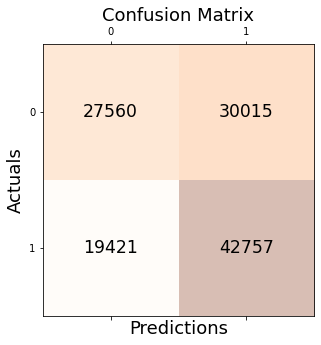

The confusion matrix shows us the number of :

* True positives : 27560 

* True negatives : 30015 

* False positives: 19421 

* False negatives: 42757 



In [283]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:',conf_matrix[1][0] ,'\n')
print('* False negatives:',conf_matrix[1][1] ,'\n')

### Classification Report

In [284]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.48      0.53     57575
         1.0       0.59      0.69      0.63     62178

    accuracy                           0.59    119753
   macro avg       0.59      0.58      0.58    119753
weighted avg       0.59      0.59      0.58    119753



### Accuracy Score

In [285]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 58.72 %

Accuracy score using cross validation: 58.9 %



Model accuracy is a machine learning model performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations.

The accuracy rate is great but it doesn’t tell us anything about the errors our machine learning models make on new data we haven’t seen before.

Mathematically, it represents the ratio of the sum of true positive and true negatives out of all the predictions.

### Precision Score

In [286]:
print("Precision score:", round((precision_score(y_test, y_pred, average='macro')*100), 2), '%\n')

Precision score: 58.71 %



The precision score is a useful measure of the success of prediction when the classes are very imbalanced.

Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

### Recall Score

In [287]:
print("Recall score:", round((metrics.recall_score(y_test, y_pred)*100), 2), '%\n')

Recall score: 68.77 %



Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made.

Recall score is a useful measure of success of prediction when the classes are very imbalanced. 

Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

### F1 Score

In [288]:
print("F1 Score:", round((metrics.f1_score(y_test, y_pred))*100), 2, '%\n')

F1 Score: 63 2 %



F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively.

### ROC Curve

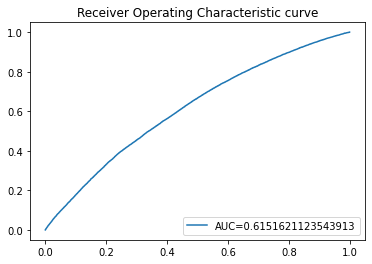

In [289]:
prediction_prob = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

This curve displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes.

# Decision Tree

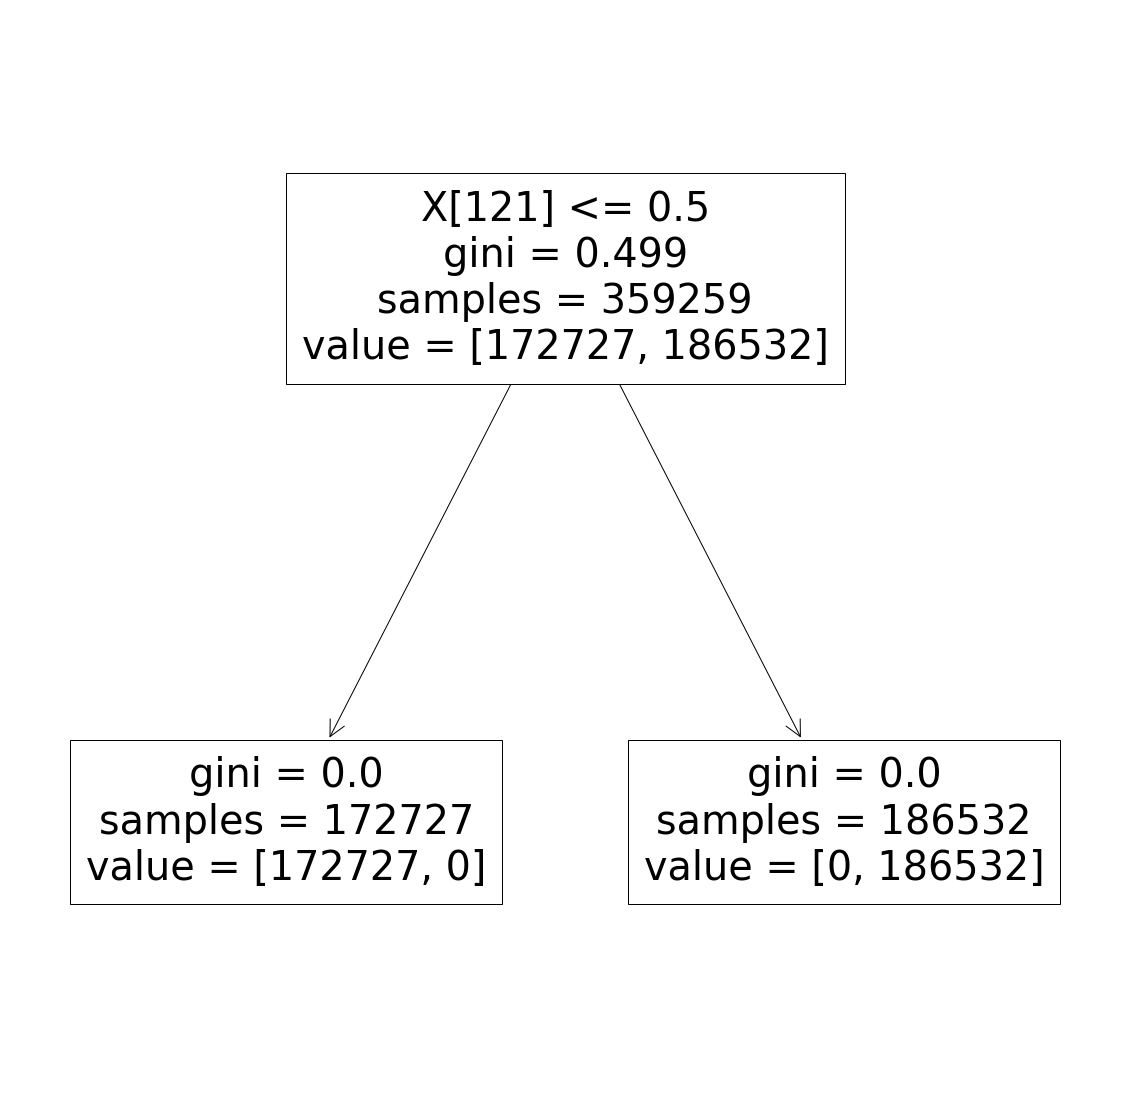

In [290]:
DT = DecisionTreeClassifier(criterion='gini', min_samples_split=2)
DT.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DT)
plt.show()

## Model testing

In [291]:
y_pred = DT.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0. 1. 1. ... 0. 0. 1.] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model evaluation

### Confusion Matrix

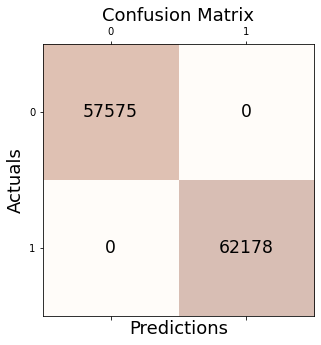

The confusion matrix shows us the number of :

* True positives : 57575 

* True negatives : 0 

* False positives: 0 

* False negatives: 62178 



In [292]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### Classification report

In [293]:
print("Classification report:\n\n", classification_report(y_test, y_pred))

Classification report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57575
         1.0       1.00      1.00      1.00     62178

    accuracy                           1.00    119753
   macro avg       1.00      1.00      1.00    119753
weighted avg       1.00      1.00      1.00    119753



### Accuracy Score

In [294]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(DT, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 100.0 %

Accuracy score using cross validation: 100.0 %



# Random Forest

In [295]:
RF = RandomForestClassifier()

In [296]:
RF.fit(X_train, y_train)

RandomForestClassifier()

## Model testing

In [297]:
y_pred = RF.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0. 1. 1. ... 0. 0. 1.] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model evaluation

### Confusion Matrix

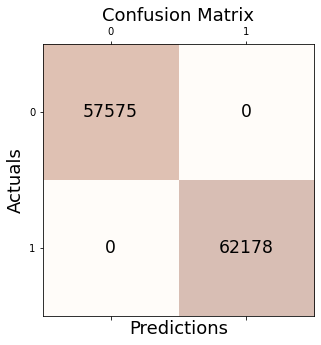

The confusion matrix shows us the number of :

* True positives : 57575 

* True negatives : 0 

* False positives: 0 

* False negatives: 62178 



In [298]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### Classification Report

In [299]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57575
         1.0       1.00      1.00      1.00     62178

    accuracy                           1.00    119753
   macro avg       1.00      1.00      1.00    119753
weighted avg       1.00      1.00      1.00    119753



### Accuracy Score

In [300]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(RF, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 100.0 %

Accuracy score using cross validation: 100.0 %



# XGBoost

In [301]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Model training

In [302]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
bst = xgb.train(param, dtrain, num_round)

[11:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [303]:
bst.dump_model('dump.raw.txt')
f = open('dump.raw.txt', 'r')
print(f.read())

booster[0]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.449994147
	2:leaf=-0.224997312
booster[1]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.224997088
	2:leaf=0.449994594
booster[2]:
0:leaf=-0.224998608
booster[3]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.302744657
	2:leaf=-0.200604156
booster[4]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.200603977
	2:leaf=0.302744836
booster[5]:
0:leaf=-0.200605482
booster[6]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.24233368
	2:leaf=-0.185299397
booster[7]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.185299188
	2:leaf=0.242333815
booster[8]:
0:leaf=-0.185300842
booster[9]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.210205182
	2:leaf=-0.175068453
booster[10]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.17506817
	2:leaf=0.210205317
booster[11]:
0:leaf=-0.175070167
booster[12]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.190954134
	2:leaf=-0.16801405
booster[13]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.168013707
	2:leaf=0.190954342
b

## Model Testing

In [304]:
probs_predictions = bst.predict(dtest)
y_pred = np.asarray([np.argmax(line) for line in probs_predictions])
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0 1 1 ... 0 0 1] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model Evaluation

### Classification Report

In [305]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57575
         1.0       1.00      1.00      1.00     62178

    accuracy                           1.00    119753
   macro avg       1.00      1.00      1.00    119753
weighted avg       1.00      1.00      1.00    119753



### Confusion Matrix

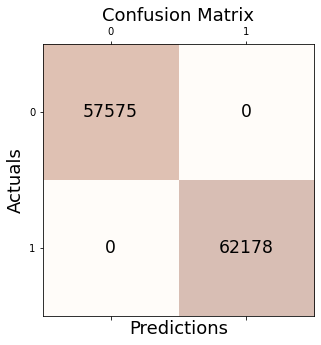

The confusion matrix shows us the number of :

* True positives : 57575 

* True negatives : 0 

* False positives: 0 

* False negatives: 62178 



In [306]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

# Conclusion

The data given was very unbalanced, we had to use oversampling to balance it to get accurate models.

We can see that the least efficient model was the logistic regression.